In this notebook, I created and trained the autoencoder in the time domain

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive/')
%cd gdrive/'My Drive'/Internship/Project

Mounted at /content/gdrive/
/content/gdrive/My Drive/Internship/Project


In [ ]:
%run Code/Final/DataPreparation.ipynb

In [ ]:
%run Code/Final/Performance_metrics.ipynb

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import os
from sklearn.preprocessing import RobustScaler
from pickle import dump, load

from tqdm.notebook import trange, tqdm
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, LeakyReLU, ReLU, Activation, Dropout, PReLU, \
                                    BatchNormalization, Flatten, Dense, Reshape, Input, AveragePooling1D, UpSampling1D

from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle

In [ ]:
# load training data
file_signal = h5py.File('Data/train_folder.h5', 'r')
data = file_signal['data'][()]
bad_quality = file_signal['bad_quality'][()]
recording_endings = file_signal['recording_endings'][()]
file_signal.close()

In [ ]:
# separate normal from anomalous data
data_clean = np.delete(data, bad_quality, axis=0)
d_anom = data[bad_quality]

In [ ]:
# shuffle data and separate the to training and validation set
data_clean = shuffle(data_clean)
d_train = fourier_clean[:int(data_clean.shape[0]*0.7)]
d_val = fourier_clean[int(data_clean.shape[0]*0.7):]

In [ ]:
class ConvAutoencoder:
  '''
  Based on https://www.pyimagesearch.com/2020/02/24/denoising-autoencoders-with-keras-tensorflow-and-deep-learning/
  kernel: The size of the convolutional kernels, chosen to be the same for simplicity
  filters: Number of filters/units the encoder and decoder will learn, respectively
  snippet_len: Length of the input signal (default 500/4=125).
  latentDim: Dimensionality of the latent-space representation.
  channels: the number of channels in the signal
  dropout: the dropout rate to be added in the convolutional layers
  '''

  @staticmethod
  def build(kernel, filters, latentDim, dil=1, snippet_len=125,  channels=4, dropout=0.3):  

    # initialize the input shape to be "channels last" along with the channels dimension itself
    inputShape = (snippet_len, channels)

    # define the input to the encoder
    inputs = Input(shape=inputShape)

    x = inputs
    # loop over the number of filters
    for f in filters:
      x = Conv1D(f, kernel, padding="same", dilation_rate=dil,
                #  kernel_regularizer='l1', bias_regularizer='l1',
                 )(x)
      x = PReLU()(x)

      if dropout != 0:
        x = Dropout(dropout)(x)

    # flatten the network and then construct our latent vector
    volumeSize = K.int_shape(x)

    x = Flatten()(x)
    latent = Dense(latentDim)(x)

    # build the encoder model
    encoder = Model(inputs, latent, name="encoder")

    # start building the decoder model which will accept the output of the encoder as its inputs
    latentInputs = Input(shape=(latentDim))
    x = Dense(np.prod(volumeSize[1:]))(latentInputs)
    x = Reshape((volumeSize[1], volumeSize[2]))(x)

    # loop over our number of filters again, but this time in reverse order
    for f in filters[::-1]:
      x = Conv1DTranspose(f, kernel, padding="same", dilation_rate=dil, 
                          # kernel_regularizer='l1', bias_regularizer='l1',
                          )(x)
      x = PReLU()(x)
      
      if dropout != 0:
        x = Dropout(dropout)(x)

    # apply a single CONV_TRANSPOSE layer used to recover the original depth of the signal
    x = Conv1DTranspose(channels, kernel, padding="same", dilation_rate=dil)(x)
    outputs = x
    
    # build the decoder model
    decoder = Model(latentInputs, outputs, name="decoder")

    # our autoencoder is the encoder + decoder
    autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")

    # return a 3-tuple of the encoder, decoder, and autoencoder
    return (encoder, decoder, autoencoder)

In [ ]:
# intialize the autoencoder
(encoder, decoder, autoencoder) = ConvAutoencoder.build(kernel=7, filters=(120,60), latentDim=60 , dil=1, dropout=0.3)
INIT_LR = 1e-4
EPOCHS = 150
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss=tf.keras.losses.mae, optimizer=opt)          
autoencoder.summary()

b_size = 16

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 125, 4)]          0         
_________________________________________________________________
encoder (Functional)         (None, 60)                526500    
_________________________________________________________________
decoder (Functional)         (None, 125, 4)            559144    
Total params: 1,085,644
Trainable params: 1,085,644
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# define the checkpoint
checkpoint_train = ModelCheckpoint('checkpoint_cnn_time_train.h5', monitor='loss', verbose=1, save_best_only=True, mode='min')
checkpoint_val = ModelCheckpoint('checkpoint_cnn_time_val.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint_train, checkpoint_val]

In [ ]:
H = autoencoder.fit(x=d_train, y=d_train, batch_size=b_size, epochs=EPOCHS, validation_data=(d_val, d_val),
                    callbacks=callbacks_list, verbose=2
                    ) 

Epoch 1/200

Epoch 00001: loss improved from inf to 0.62859, saving model to checkpoint_cnn_time_train.h5

Epoch 00001: val_loss improved from inf to 0.62146, saving model to checkpoint_cnn_time_val.h5
31392/31392 - 252s - loss: 0.6286 - val_loss: 0.6215
Epoch 2/200

Epoch 00002: loss did not improve from 0.62859

Epoch 00002: val_loss improved from 0.62146 to 0.61537, saving model to checkpoint_cnn_time_val.h5
31392/31392 - 246s - loss: 0.6667 - val_loss: 0.6154
Epoch 3/200

Epoch 00003: loss did not improve from 0.62859

Epoch 00003: val_loss did not improve from 0.61537
31392/31392 - 246s - loss: 0.6809 - val_loss: 0.6197
Epoch 4/200

Epoch 00004: loss did not improve from 0.62859

Epoch 00004: val_loss did not improve from 0.61537
31392/31392 - 245s - loss: 0.7188 - val_loss: 0.6269
Epoch 5/200

Epoch 00005: loss improved from 0.62859 to 0.62512, saving model to checkpoint_cnn_time_train.h5

Epoch 00005: val_loss did not improve from 0.61537
31392/31392 - 243s - loss: 0.6251 - val_

In [ ]:
original = d_anom[:1000]
reconstructed = autoencoder.predict(original)

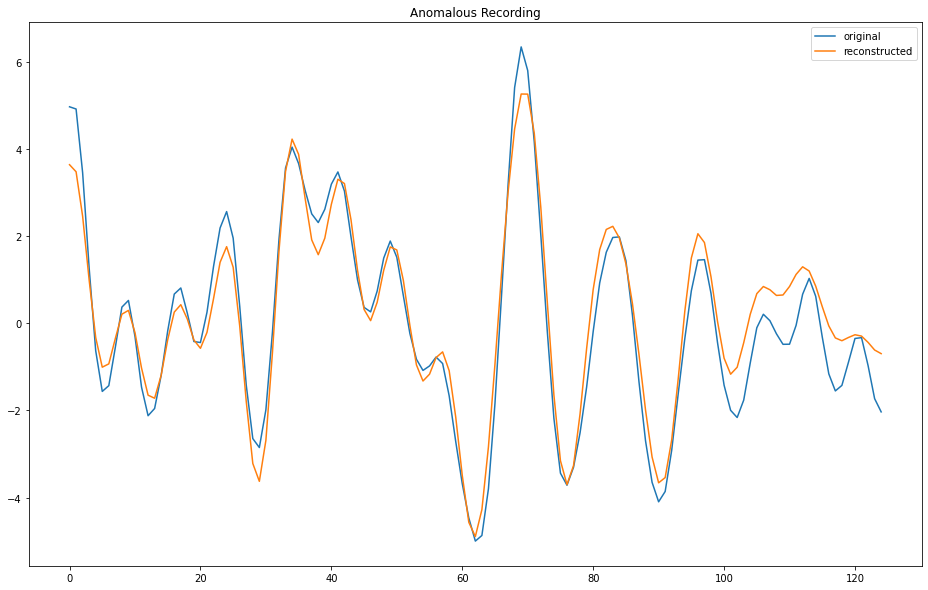

In [ ]:
plt.figure(figsize=(16,10))
id = 10
channel = 2
plt.plot(np.arange(len(original[0,:,0])), original[id,:,channel], label='original')
plt.plot(np.arange(len(original[0,:,0])), reconstructed[id,:,channel],  label='reconstructed') 
plt.title('Anomalous Recording')
plt.legend()
plt.show()

In [ ]:
original = data_clean[:1000]
reconstructed = autoencoder.predict(original)

In [ ]:
plt.figure(figsize=(16,10))
id = 40
plt.plot(np.arange(len(original[0,:,0])), original[id,:,0], label='original')
plt.plot(np.arange(len(original[0,:,0])), reconstructed[id,:,0],  label='reconstructed') 
plt.legend()
plt.show()